# Stock-prediction
The full code of the Data-Exploration Project

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from yahoo_fin import stock_info as si
from collections import deque
import seaborn as sns
sns.set(font_scale=1.25,rc={'figure.figsize':(14,12)})

import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# set seed
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [3]:
# shuffle two arrays in the same way
def shuffle_in_unison(a, b):
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

'''
Loads the Data from Yahoo finance and prepares it for later use
<params>
    ticker: ticker names from yahoo finance / Pandas Dataframe for saved data
    n_steps: sequence size
    lookup_step: how far into the future should be predicted
    test_size: train/test split in percent
    feature_columns: list of columns to make sure that everything exists
return: result Dataframe
'''
def load_data(ticker, n_steps=50, lookup_step=1, test_size=0.2, 
              feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    
    # is it a ticker or data loaded from csv
    if isinstance(ticker, str):
        # load new data
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # csv
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    
    # result to be returned
    result = {}
    result['df'] = df.copy()
    
    # making sure that all columns exist
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
        
    # add date
    if "date" not in df.columns:
        df["date"] = df.index
    
    # scales data from 0 to 1
    column_scaler = {}
    for column in feature_columns:
        scaler = preprocessing.MinMaxScaler()
        df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
        column_scaler[column] = scaler
    # add the MinMaxScaler instances to the result returned
    result["column_scaler"] = column_scaler
    
    # adds the label as a column by shifting with the lookup step
    df['future'] = df['adjclose'].shift(-lookup_step)
    
    # last labels contain NaNs 
    # shouldnt be dropped
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)
    
    # build the sequences 
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    
    result['last_sequence'] = last_sequence
    
    # create the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
        
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # split the dataset randomly
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=True)
    
    # shuffle the datasets for training
    shuffle_in_unison(result["X_train"], result["y_train"])
    shuffle_in_unison(result["X_test"], result["y_test"])

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    
    return result

In [4]:
'''
Builds the neural Network model
<params>
    sequence_length: the length of one sequence
    n_features: the number of feature columns that is inserted as a input
    units: number of neurons per layer
    cell: specifies the kind of layer added (in this case we are using LSTM)
    n_layers: number of layers
    dropout: the dropout rate that is applied to the input (in percent)
    loss: the loss-funktion that is used
    optimizer: the optimizer that is used
return: build model
'''
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="huber_loss", optimizer="adam"):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
        
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [5]:
'''
plots the predicted price alongside the true price
<params>
    test_df: in this case the final Dataframe from get_final_df()
''' 
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [6]:
'''
creates the final Dataframe with the features, the true prices and the predicted prices
<params>
    model: the model that was loaded with the trained weigths
    data: the data Dataframe from load_data()
returns: the final Dataframe
'''
def get_final_df(model, data):
    # if predicted future price is higher than the current
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    
    # if the predicted future price is lower than the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # perform prediction and get prices
    y_pred = model.predict(X_test)    
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, final_df["adjclose"], final_df[f"adjclose_{LOOKUP_STEP}"], final_df[f"true_adjclose_{LOOKUP_STEP}"]))
    
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, final_df["adjclose"], final_df[f"adjclose_{LOOKUP_STEP}"], final_df[f"true_adjclose_{LOOKUP_STEP}"]))
    
    return final_df

In [7]:
'''
gives the predicted future price
<params>
    model: the model that was loaded with the trained weigths
    data: the data Dataframe from load_data()
return: predicted future price
'''
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    # get the prediction 
    prediction = model.predict(last_sequence)
    
    # invert scaling
    predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    
    return predicted_price

In [8]:
import os
from tensorflow.keras.layers import LSTM

# sequence length
N_STEPS = 50

# Lookup step, 1 is the next day
LOOKUP_STEP = 15

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

### model parameters
N_LAYERS = 2

# LSTM cell
CELL = LSTM

# number of LSTM neurons
UNITS = 256

# applies Dropout to the input
DROPOUT = 0.4

# training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 5

# which stock to use as ticker
ticker = "TMV.DE"
ticker_data_filename = os.path.join("data", f"{ticker}.csv")

# model name based on params. used as filename for the saved weights 
model_name = f"{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [9]:
# create these folders if they does not exist
if not os.path.isdir("model_weigths"):
    os.mkdir("model_weigths")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [10]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)

# ModelCheckpoint saves the best model
checkpointer = ModelCheckpoint(os.path.join("model_weigths", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
# tensorboard to log changes
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model
history = model.fit(data["X_train"], data["y_train"], batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard], verbose=1)

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.2148
Epoch 1: val_loss improved from inf to 0.00580, saving model to model_weigths\TMV.DE-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
9/9 [==============================] - 10s 603ms/step - loss: 0.0430 - mean_absolute_error: 0.2148 - val_loss: 0.0058 - val_mean_absolute_error: 0.0813
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0982
Epoch 2: val_loss did not improve from 0.00580
9/9 [==============================] - 4s 457ms/step - loss: 0.0081 - mean_absolute_error: 0.0982 - val_loss: 0.0068 - val_mean_absolute_error: 0.0870
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0933
Epoch 3: val_loss did not improve from 0.00580
9/9 [==============================] - 4s 444ms/step - loss: 0.0082 - mean_absolute_error: 0.0933 - val_loss: 0.0082 - val_mean_absolute_error: 0.0948
Epo

In [11]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

In [12]:
# load optimal model weights from results folder
model_path = os.path.join("model_weigths", model_name) + ".h5"
model.load_weights(model_path)
print(model_name)

TMV.DE-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256


In [14]:
stored_data = pd.read_csv(ticker_data_filename)
data = load_data(stored_data, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# evaluate the model
loss, _ = model.evaluate(data["X_test"], data["y_test"], verbose=0)


In [15]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# calculate the mean absolute error
mae = mean_absolute_error(final_df[f"true_adjclose_{LOOKUP_STEP}"], final_df[f"adjclose_{LOOKUP_STEP}"])

5/5 [==============================] - 2s 103ms/step


In [16]:
# predict the future price
future_price = predict(model, data)

1/1 [==============================] - 0s 39ms/step


In [17]:
# accuracy as percentage of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit

# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [20]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mae)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 10.18$
huber_loss loss: 0.007311748340725899
Mean Absolute Error: 4.013368089069693
Accuracy score: 0.5193798449612403
Total buy profit: 12.789999008178732
Total sell profit: 45.36000156402578
Total profit: 58.15000057220451
Profit per trade: 0.4507751982341435


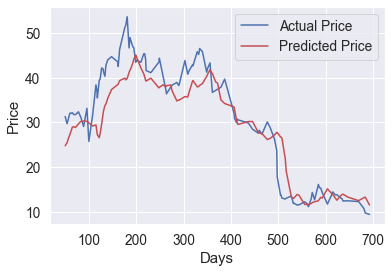

In [21]:
# plot true/pred prices graph
plot_graph(final_df)